In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import numpy as np
import time
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import data
try:
    from localgraphclustering import *
except:
    # when the package is not installed, import the local version instead. 
    # the notebook must be placed in the original "notebooks/" folder
    sys.path.append("../")
    from localgraphclustering import *
    
from affinity_kimon import affinity
from skimage.color import rgb2gray
from skimage import data, segmentation, color
from skimage.future import graph
from skimage.segmentation import mark_boundaries

## Load image from skimage

In [2]:
img = data.astronaut()
[m,n] = img.shape[0:2]
n_pixels = m*n

## Construct an affinity matrix using our Cython implementation in affinity_kimon. You can replace this with your own adjacency matrix. If you want to use our implementation, please remember to recompile affinity_kimon.pyx under the notebooks folder. Note that this pipeline is not the most efficient for image segmentation. This pipeline uses only colour and position cues. Our objective is to demonstrate how effective local graph clustering is.

In [26]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,0.4,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

## Load the matrix in the LocalGraphClustering API

In [31]:
g = GraphLocal()
g.from_sparse_adjacency(A)

## Find a single segment in the image using local graph clustering. Ignore warnings about weighted graphs.

0.506554126739502


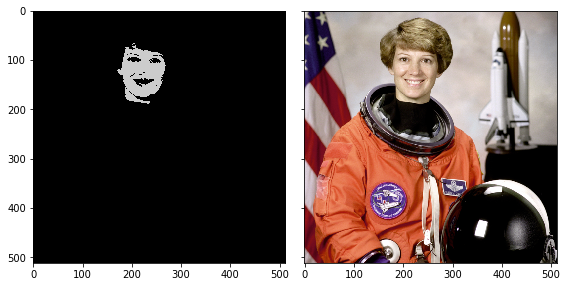

In [23]:
start = time.time()
refnode = [120*m + 220]
output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=0.03,rho=1.0e-15,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 
end = time.time()
print(end - start)

labels = np.zeros(n_pixels)
labels[output[0]] = 1

fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 8))

ax[0].imshow(labels.reshape((m,n)), cmap='nipy_spectral')
ax[1].imshow(img)

#for a in ax:
    #a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral local graph clustering.

In [24]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

436.24840784072876ed:  90.017318725585945


## Plot

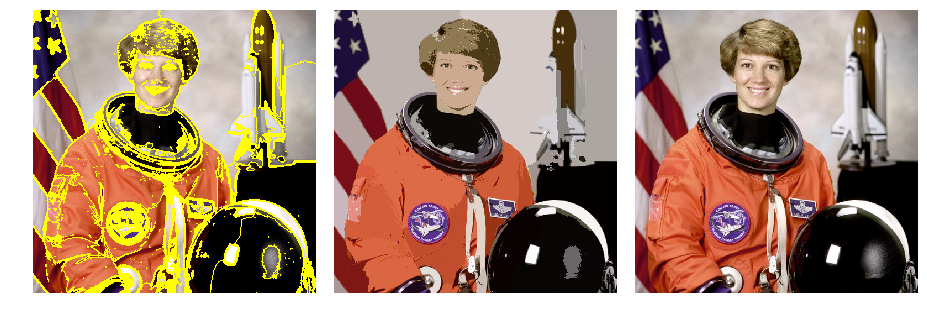

In [25]:
out_lgc = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Segment the whole image using spectral + flow (MQI) local graph clustering

In [26]:
start = time.time()
# Compute the embeddings X and the pairwise distance matrix Z.
labels, info = graph_segmentation_with_improve(g,rho_list=[1.0e-15,1.0e-1],alpha_list=[0.03,1.0e-1],iterations=1000000,ratio=0.1,nsamples_from_rho=1,nsamples_from_alpha=30,normalized_objective=False,njobs=6,how_many_in_parallel=6)
end = time.time()
print(end - start)

501.26784801483154ed:  90.023040771484385


## Visualize the result

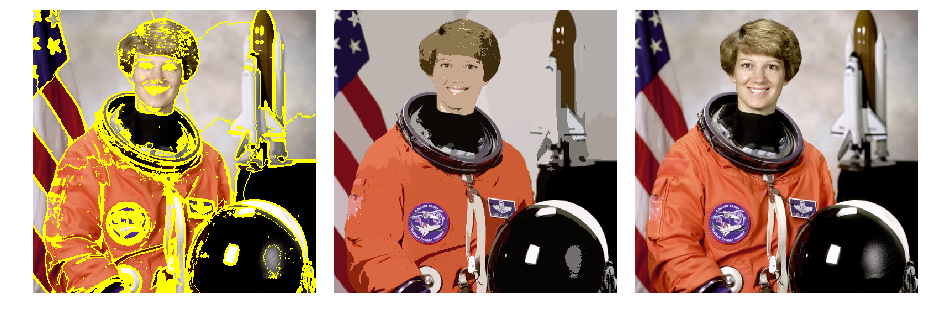

In [27]:
out_lgc_with_improve = color.label2rgb(labels.reshape((m,n)), img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, labels.reshape((m,n))))
ax[1].imshow(out_lgc_with_improve)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Run the classic normalized cut from skimage

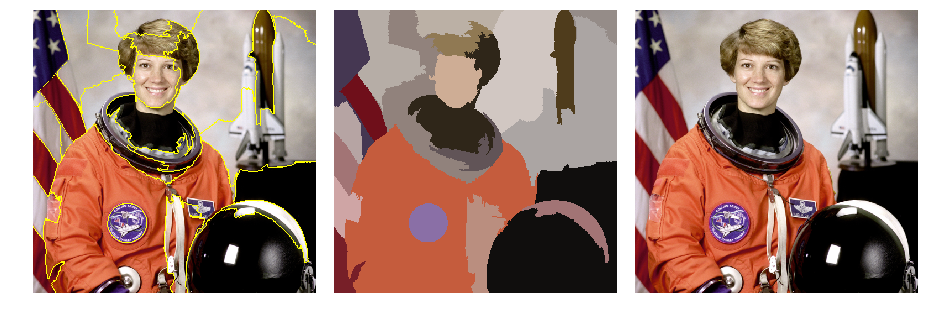

In [28]:
labels_slic = segmentation.slic(img, n_segments=100)
rag_ = graph.rag_mean_color(img, labels_slic, mode='similarity')
new_labels_slic = graph.cut_normalized(labels_slic, rag_, thresh=0.001, num_cuts=10)
out_ncuts = color.label2rgb(new_labels_slic, img, kind='avg')

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(13, 13))

ax[0].imshow(mark_boundaries(img, new_labels_slic))
ax[1].imshow(out_ncuts)
ax[2].imshow(img)

for a in ax:
    a.axis('off')

plt.tight_layout()

## Slice image using slic from skimage

In [29]:
labels = segmentation.slic(img, compactness=30, n_segments=400)
out_slic = color.label2rgb(labels, img, kind='avg')

## Visualize all results

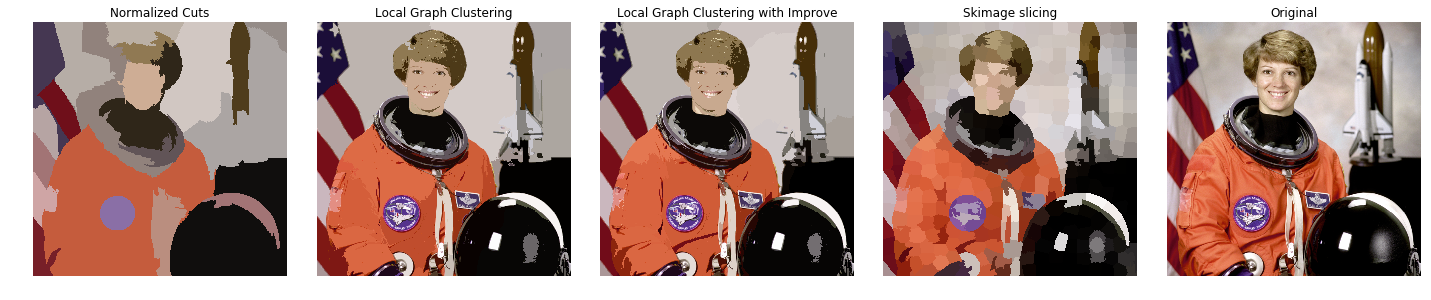

In [30]:
fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(out_ncuts)
ax[1].imshow(out_lgc)
ax[2].imshow(out_lgc_with_improve)
ax[3].imshow(out_slic)
ax[4].imshow(img)

ax[0].set_title('Normalized Cuts')
ax[1].set_title('Local Graph Clustering')
ax[2].set_title('Local Graph Clustering with Improve')
ax[3].set_title('Skimage slicing')
ax[4].set_title('Original')

for a in ax:
    a.axis('off')

plt.tight_layout()

## Compute NCP plot

In [31]:
import warnings
warnings.filterwarnings('ignore')

ncp_instance = NCPData(g,store_output_clusters=True,do_largest_component=False)
ncp_instance.approxPageRank(ratio=1,nthreads=6,method = "l1reg-rand")

approxPageRank:ncpapr_l1reg-rand:  101.0 neighborhoods
approxPageRank:ncpapr_l1reg-rand:  216.2 localmin rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  354.7 localmin rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  507.6 random_node rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  661.9 random_node rho=1.0e-04
approxPageRank:ncpapr_l1reg-rand:  816.7 random_neighborhood rho=1.0e-05
approxPageRank:ncpapr_l1reg-rand:  974.7 random_neighborhood rho=1.0e-04


## Make an interactive NCP

In [32]:
p = NCPPlots(ncp_instance)
p.cond_by_size_itrv();

## Reload the data and make sure the graph is a connected component

In [44]:
data, row, col = affinity(n_pixels,m,n,80.0,7.0e+1,max(m,n)/1.0e+1,0.0,img.astype(float))
A = sp.sparse.csc_matrix((data, (row, col)), shape=(n_pixels, n_pixels))

g = GraphLocal()
g.from_sparse_adjacency(A)

g.is_disconnected()

There are  1  connected components in the graph
The graph is not a disconnected graph.


False

## Run spectral

54.27253603935242
conductance:  0.14030524076157874


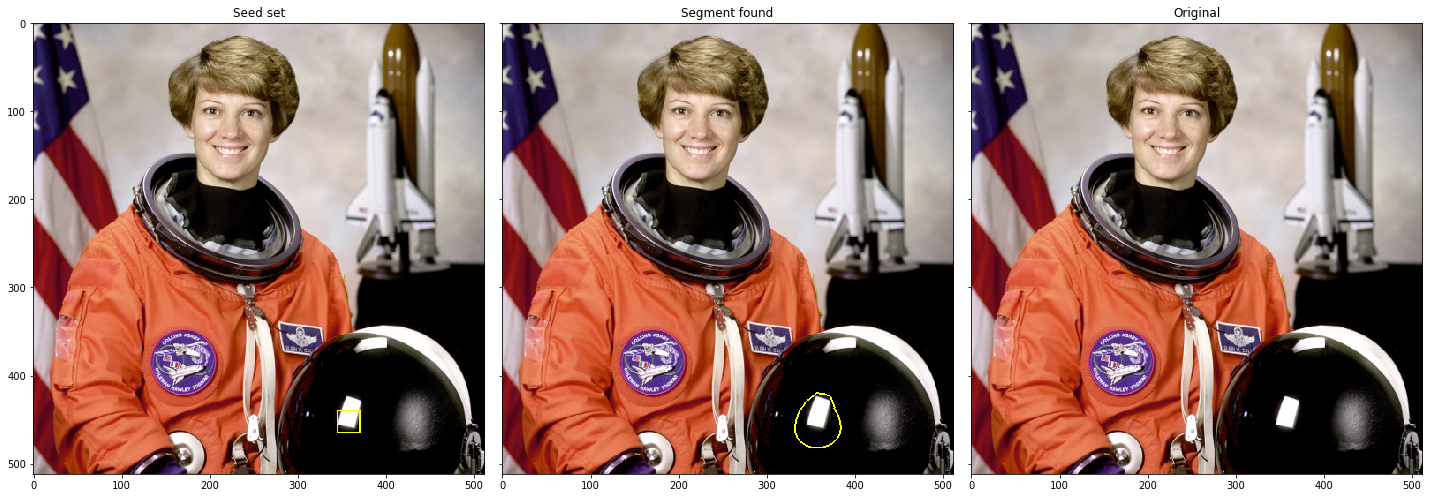

In [45]:
start = time.time()

width = 25
i = 440
j = 345

refnode = []

for p in range(i,i+width):
    
    for q in range(j,j+width):
        
        refnode.append(p*n + q)

#refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.8]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-6,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels_seed = np.zeros(n_pixels, dtype=np.int32)
labels_seed[refnode] = 1

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found')
ax[2].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(output[0]))

## Run MQI

In [46]:
output_mqi = flow_clustering(g,refnode,method="mqi_weighted")

labels_mqi = np.zeros(n_pixels, dtype=np.int32)
labels_mqi[output_mqi[0]] = 1

print("Improved conductance: ", output_mqi[1])

Improved conductance:  0.11701710190611248


## Visualize the results

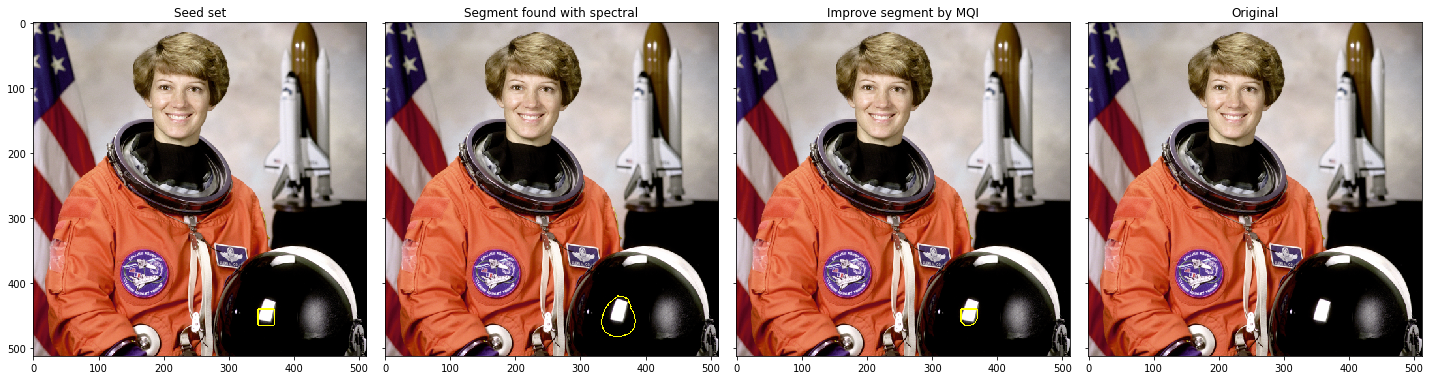

In [47]:
fig, ax = plt.subplots(ncols=4, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(mark_boundaries(img, labels_mqi.reshape((m,n)),mode='thick'))
ax[3].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found with spectral')
ax[2].set_title('Improve segment by MQI')
ax[3].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

## Rerun spectral to show that MQI does not work properly

34.80793309211731
conductance:  8.181932525718725e-06


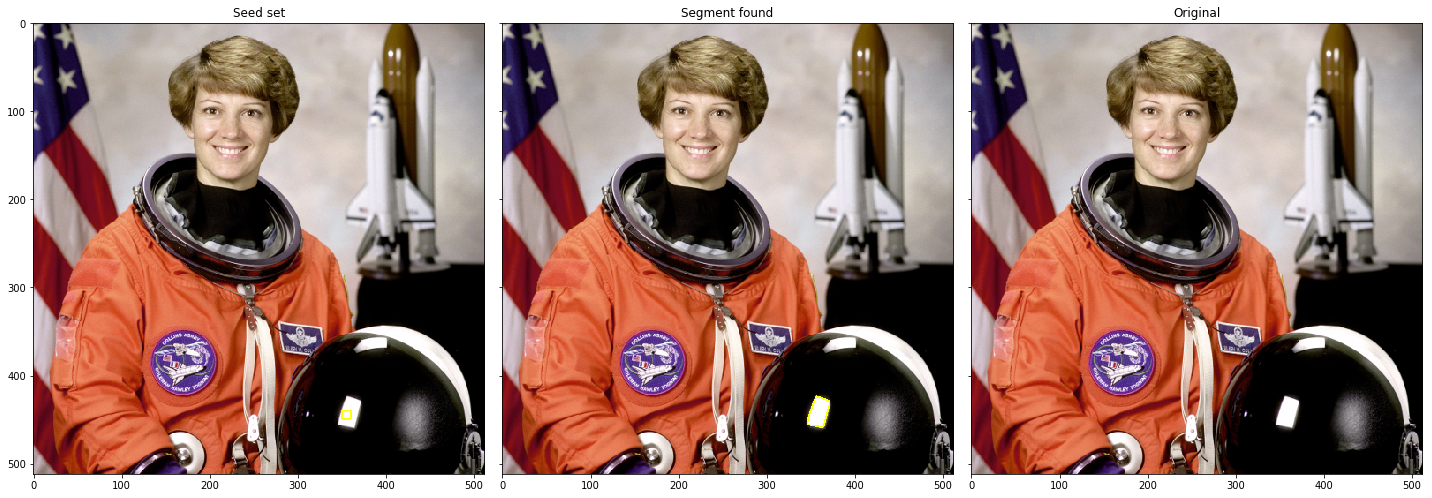

In [48]:
start = time.time()

width = 10
i = 440
j = 350

refnode = []

for p in range(i,i+width):
    
    for q in range(j,j+width):
        
        refnode.append(p*n + q)

#refnode = [420*n + 390]

nsamples_from_alpha = 50
alpha_list = [1.0e-2,0.8]

sampled_alphas = list(np.geomspace(alpha_list[0], alpha_list[1], nsamples_from_alpha, endpoint=True))

min_crit = 10000
min_crit_embedding = 0

for alpha in list(reversed(sampled_alphas)):

    output = approximate_PageRank(g,refnode,method='l1reg-rand',alpha=alpha,rho=1.0e-7,normalize=False,normalized_objective=False,epsilon=1.0e-2,iterations=1000000) 

    conductance = g.compute_conductance(output[0])

    crit = conductance
    if crit <= min_crit:
        min_crit = crit
        min_crit_embedding = output

end = time.time()
print(end - start)

labels_seed = np.zeros(n_pixels, dtype=np.int32)
labels_seed[refnode] = 1

labels = np.zeros(n_pixels, dtype=np.int32)
labels[min_crit_embedding[0]] = 1

fig, ax = plt.subplots(ncols=3, sharex=True, sharey=True, figsize=(20, 20))

ax[0].imshow(mark_boundaries(img, labels_seed.reshape((m,n)),mode='thick'))
ax[1].imshow(mark_boundaries(img, labels.reshape((m,n)),mode='thick'))
ax[2].imshow(img)

ax[0].set_title('Seed set')
ax[1].set_title('Segment found')
ax[2].set_title('Original')

# for a in ax:
#     a.axis('off')
    
plt.tight_layout()

print("conductance: ", g.compute_conductance(output[0]))